<a href="https://colab.research.google.com/github/Saultr21/IA-Y-BIGDATA/blob/main/PRO/Ajedrez/Ajedrez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saúl Tomás Trujillo Rodríguez

# 1. Importar las bibliotecas necesarias

In [1]:
# 1. Importar las bibliotecas necesarias
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.resnet50 import preprocess_input
# Instalar imbalanced-learn (si no está instalado)
!pip install imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

# 2. Definir parámetros e información del conjunto de datos

In [2]:
# Descargar el conjunto de datos de imágenes de piezas de ajedrez
# Nota: Reemplaza la URL con la dirección real del dataset o súbelo manualmente

from google.colab import files

# Descomprimir el archivo ZIP (si se subió)
!unzip -q ajedrez.zip -d ./Chessman-image-dataset


replace ./Chessman-image-dataset/Chessman-image-dataset/Chess/Bishop/00000000.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# 3. Función para cargar y preprocesar el dataset

In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
CLASSES = ['Bishop', 'King', 'Knight', 'Pawn', 'Queen', 'Rook']
NUM_CLASSES = len(CLASSES)
DATASET_PATH = "/content/Chessman-image-dataset/Chessman-image-dataset/Chess"

# 4. Cargar datos y preparar el conjunto

In [4]:
#  3. Función para cargar y preprocesar el dataset
def load_dataset(dataset_path, classes):
    X = []
    y = []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(dataset_path, class_name)
        images = [img for img in os.listdir(class_dir) if img.endswith(('.jpg', '.png'))]
        print(f"Cargando {len(images)} imágenes de {class_name}")
        for img_name in images:
            img_path = os.path.join(class_dir, img_name)
            image = cv2.imread(img_path)
            if image is not None:
                # Redimensionar la imagen al tamaño definido
                resized = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
                X.append(resized)
                y.append(label)
    return np.array(X), np.array(y)

# Cargar datos
X, y = load_dataset(DATASET_PATH, CLASSES)

# Dividir en conjuntos de entrenamiento y prueba (90% train - 10% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)

# Convertir las imágenes a float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Aplicar preprocesamiento (solo para el conjunto de test; el generador se encargará en el entrenamiento)
X_test = preprocess_input(X_test)

# 4. Oversampling para balancear las clases en el conjunto de entrenamiento
print("Distribución original de clases:", dict(zip(*np.unique(y_train, return_counts=True))))

# Aplanar las imágenes para que el oversampler trabaje en 2D
num_samples, height, width, channels = X_train.shape
X_train_flat = X_train.reshape((num_samples, -1))

# Aplicar oversampling
ros = RandomOverSampler(random_state=42)
X_resampled_flat, y_resampled = ros.fit_resample(X_train_flat, y_train)

# Volver a dar forma a las imágenes
X_resampled = X_resampled_flat.reshape((-1, height, width, channels))
print("Distribución de clases después de oversampling:", dict(zip(*np.unique(y_resampled, return_counts=True))))

# Convertir las etiquetas a one-hot encoding
y_resampled_cat = keras.utils.to_categorical(y_resampled, NUM_CLASSES)
y_test_cat = keras.utils.to_categorical(y_test, NUM_CLASSES)

# 5. Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    preprocessing_function=preprocess_input  # Aplica el mismo preprocesamiento de ResNet50
)



Cargando 83 imágenes de Bishop
Cargando 73 imágenes de King
Cargando 103 imágenes de Knight
Cargando 104 imágenes de Pawn
Cargando 74 imágenes de Queen
Cargando 97 imágenes de Rook
Distribución original de clases: {0: 75, 1: 66, 2: 93, 3: 93, 4: 66, 5: 87}
Distribución de clases después de oversampling: {0: 93, 1: 93, 2: 93, 3: 93, 4: 93, 5: 93}


# 5. Crear modelo CNN con regularización y compilarlo

In [5]:
# 5. Crear el modelo CNN con ResNet50 pre-entrenado + Fine-Tuning
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Primera fase: congelar el modelo base para entrenar únicamente las capas superiores
base_model.trainable = False

model = keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compilación inicial (fase 1)
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │           3,078 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,641,926 (94.00 MB)

 Trainable params: 1,053,190 (4.02 MB)

 Non-trainable params: 23,588,736 (89.98 MB)

# 6. Entrenar el modelo

Se implementa un EarlyStopping para evitar que el modelo siga entrenando cuando la precisión de validación deje de mejorar, lo que puede ayudar a prevenir el sobreajuste.

In [8]:
#Definir callbacks para early stopping y reducción de learning rate
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)

# 7. Entrenar el modelo (Fase 1: solo capas nuevas)
history = model.fit(
    datagen.flow(X_resampled, y_resampled_cat, batch_size=BATCH_SIZE),
    epochs=10,  # Primera fase corta
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop, reduce_lr]
)

# Fase 2: Fine-tuning (descongelar parte del modelo base)
base_model.trainable = True
# Congelar las primeras 100 capas para evitar ajustes bruscos
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompilar el modelo con una tasa de aprendizaje muy baja para el fine-tuning
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history_finetune = model.fit(
    datagen.flow(X_resampled, y_resampled_cat, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_test, y_test_cat),
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 533ms/step - accuracy: 0.9516 - loss: 0.9596 - val_accuracy: 0.7407 - val_loss: 1.4990 - learning_rate: 4.0000e-06
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 471ms/step - accuracy: 0.9503 - loss: 0.9641 - val_accuracy: 0.7593 - val_loss: 1.4949 - learning_rate: 4.0000e-06
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 520ms/step - accuracy: 0.9527 - loss: 0.9444 - val_accuracy: 0.7778 - val_loss: 1.4880 - learning_rate: 4.0000e-06
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 519ms/step - accuracy: 0.9583 - loss: 0.9693 - val_accuracy: 0.7963 - val_loss: 1.4928 - learning_rate: 4.0000e-06
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 481ms/step - accuracy: 0.9382 - loss: 0.9672 - val_accuracy: 0.7778 - val_loss: 1.4929 - learning_rate: 4.0000e-06
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step - accuracy: 0.9479 - loss: 0.9824 - val_accuracy: 0.7593 - val_loss: 1.5050 - learning_rate: 4.0000e-06
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 524ms/step - accurac

# 8. Graficar métricas de entrenamiento y prueba

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8492 - loss: 1.4363

Precisión final en test: 85.19%
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step

Reporte de Clasificación por Clase:
              precision    recall  f1-score   support

      Bishop       0.88      0.88      0.88         8
        King       0.75      0.86      0.80         7
      Knight       1.00      1.00      1.00        10
        Pawn       0.79      1.00      0.88        11
       Queen       0.67      0.50      0.57         8
        Rook       1.00      0.80      0.89        10

    accuracy                           0.85        54
   macro avg       0.85      0.84      0.84        54
weighted avg       0.86      0.85      0.85        54



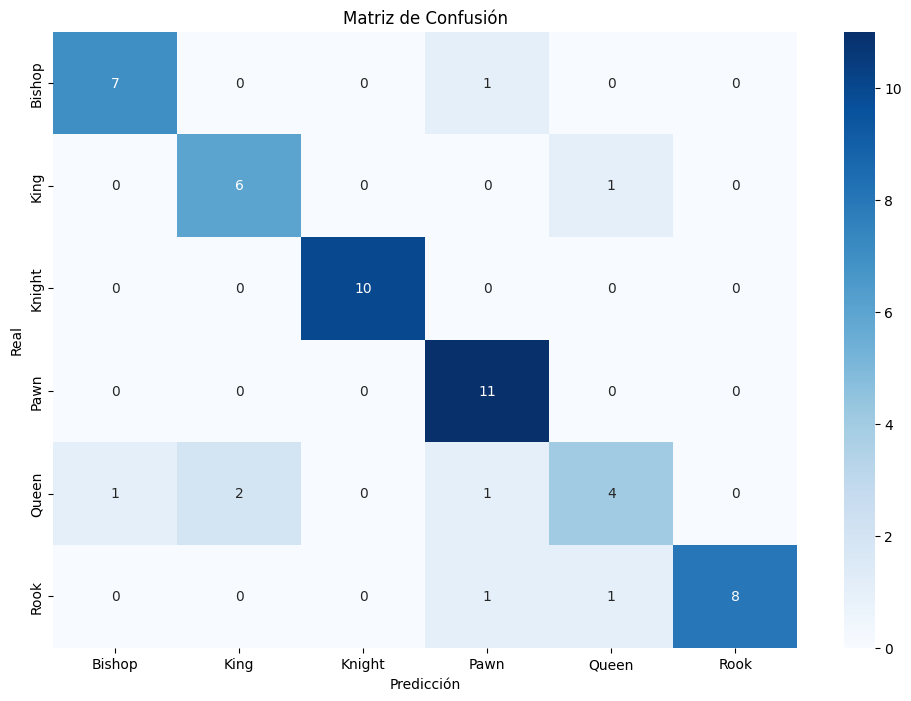

In [9]:
# 7. Evaluación del modelo
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"\nPrecisión final en test: {test_acc:.2%}")

# Reporte de clasificación
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

print("\nReporte de Clasificación por Clase:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

# Matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_true, y_pred_classes),
            annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

# 10. Función para predecir una imagen

Saving Screenshot_1.jpg to Screenshot_1 (1).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


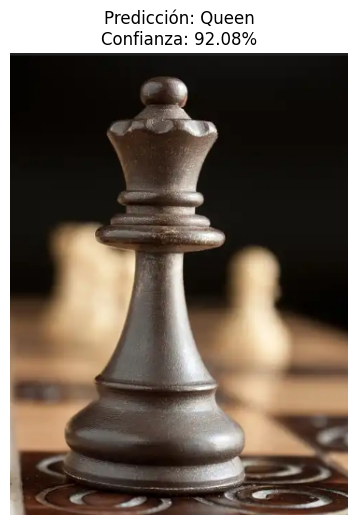

In [12]:
# 8. Función para predecir una imagen (interactiva en Colab)
def predict_chess_piece():
    uploaded = files.upload()
    if not uploaded:
        print("No se subió ninguna imagen")
        return

    image_path = list(uploaded.keys())[0]
    img = cv2.imread(image_path)

    if img is None:
        print("Error al leer la imagen")
        return

    # Procesar la imagen para la predicción
    img_processed = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_processed = img_processed.astype('float32')
    img_processed = preprocess_input(img_processed)
    img_processed = np.expand_dims(img_processed, axis=0)

    # Realizar la predicción
    prediction = model.predict(img_processed)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    # Mostrar la imagen y la predicción
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicción: {CLASSES[predicted_class]}\nConfianza: {confidence:.2%}")
    plt.axis('off')
    plt.show()

# Ejecutar la función de predicción interactiva
predict_chess_piece()